In [71]:
#imports

import time
import numpy as np
import scipy.constants as con
import scipy.optimize as opt
import scipy.linalg as la
from scipy import special
from scipy import integrate
#from scipy.optimize import root_scalar
from scipy.integrate._ivp import common as jacpack
from scipy.interpolate import interp1d 

import importlib
from numba import njit

import matplotlib.pyplot as plt


#Reaction networks
import pynucastro as pyna
reaclibrary = pyna.ReacLibLibrary()

#import H2_AoT_net as bbn_np
import np_AoT_net as bbn_np

#import bbn_test_integrate as bbn_Li
import AoT_net as bbn_Li

#import full_size_net as bbn_full
import full_AoT_net as bbn_full
import H2_AoT_net as bbn_H2

networks=[bbn_np,bbn_H2,bbn_Li,bbn_full]

importlib.reload(bbn_full)
importlib.reload(bbn_Li)
importlib.reload(bbn_np)

#number of nuclei in network, nNucs[-1]=2 to since initial condition sets n and p
nNucs=[net.nnuc if isinstance(net.nnuc, int) else net.nnuc() for net in networks]+[2]

In [72]:
#Unit conversions
timeunit =1.519*10**21  #MeV/hbar in unit of 1/second 
TMeV2T9=11.60451812 #conversion factor from MeV to 10^9K
cm3s=1.167*10**-11  #conversion factor for cm^3/s
gcm3=232012         #conversion factor for g/cm^3
molcm3=216117376    #conversion factor for mol/cm^3 (cm^3*MeV^3)/(hbar^3*c^3*Avagadro number)
meter=5.068e12      #conversion factor for m
cm=5.068e10         #conversion factor for cm
barn=389.4          #conversion factor for barn
e_mass=0.51099895   #electron mass in MeV

#constants
n_life=879.6*timeunit   #Neutron lifetime in units of MeV/hbar
Q=1.293                 #neutron proton mass difference in MeV
M_u=931.494102          #atomic mass unit in MeV
SBC=np.pi**2/60         #Stefan-Boltzmann constant in natural units
G=6.70883e-45             #gravatational constant in units of c=hbar=MeV=1
n_nu=3.046              #number of neutrino families with correction from 
                        #Nollett and Steigman, BBN and the CMB constrain neutrino coupled light WIMPs, 2015


#Setup isotopes based on Alterbbn
Y_labels=['n','p','H2','H3','He3','He4','Li6','Li7','Li8','Be7','Be9','B8','B10','B11','B12','C11','C12','C13','C14','N12','N13','N14','N15','O14','O15','O16']
Alter_Yl=["n","p","H2","H3","He3","He4","Li6","Li7","Be7","Li8","B8","Be9","B10","B11","C11","B12","C12","N12","C13","N13","C14","N14","O14","N15","O15","O16"]

fnNucs=nNucs[-2]

A=np.array([1,1,2,3,3,4,6,7,8,7,9,8,10,11,12,11,12,13,14,12,13,14,15,14,15,16])
Alter_A=[1.,1.,2.,3.,3.,4.,6.,7.,7.,8.,8.,9.,10.,11.,11.,12.,12.,12.,13.,13.,14.,14.,14.,15.,15.,16.]

Z=sorted([0,1,1,1,2,2,3,3,4,3,5,4,5,5,6,5,6,7,6,7,6,7,8,7,8,8])
Alter_Z=[0.,1.,1.,1.,2.,2.,3.,3.,4.,3.,5.,4.,5.,5.,6.,5.,6.,7.,6.,7.,6.,7.,8.,7.,8.,8.]

def Altersort(L):
    if type(L)==list:
        return [x for (a,x) in sorted(zip(zip(A,Z),L), key=lambda pair: pair[0])]
    else:
        return np.array([x for (a,x) in sorted(zip(zip(A,Z),L), key=lambda pair: pair[0])])

def PNAsort(L):
    if type(L)==list:
        return [x for (a,x) in sorted(zip(zip(Alter_Z,Alter_A),L), key=lambda pair: pair[0])]
    else:
        return np.array([x for (a,x) in sorted(zip(zip(Alter_Z,Alter_A),L), key=lambda pair: pair[0])])    


Alterspin=[0.5,0.5,1.,0.5,0.5,0.,1.,1.5,1.5,2.,2.,1.5,3.,1.5,1.5,1.,0.,1.,0.5,0.5,0.,1.,0.,0.5,0.5,0.]
spin=PNAsort(Alterspin)

Alter_mass_excess=[8.071388,7.289028,13.135825,14.949915,14.931325,2.424931,14.0864,14.9078,15.7696,20.9464,22.9212,11.34758,12.05086,8.6680,10.6506,13.3690,0.,17.3382,3.125036,5.3455,3.019916,2.863440,8.006521,0.101439,2.8554,-4.737036]
Alter_mass=[Alter_A[i]*M_u+Alter_mass_excess[i] for i in range(fnNucs)]
m_Nucs = np.array(PNAsort(Alter_mass))
m_n,m_p,m_d,m_t,m_He3,m_He4=m_Nucs[:6]

B=[(m_Nucs[1]*Z[i]+m_Nucs[0]*(A[i]-Z[i]))-m_Nucs[i] for i in range(fnNucs)]
g = 1+2*np.array(spin)

In [73]:
#Background
#Special functions og deres afledte
def L(z):
    return special.kn(2,z)/z

def M(z):
    return (3/4*special.kn(3,z)+1/4*special.kn(1,z))/z

def dMdz(z):
    return -3/z**2*special.kn(3,z) -special.kn(2,z)/z

def N(z):
    return (1/2*special.kn(4,z)+1/2*special.kn(2,z))/z



def rho_gamma(T):   #photon energy density
    return (np.pi**2)/15*T**4 

def drho_gamma(T):  #derivative
    return 4*(np.pi**2)/15*T**3 

def P_gamma(T):     #photon pressure
    return rho_gamma(T)/3

    
def rho_e(T): #electron/positron density, chemical potential assumed to be 0 so cosh(phi*n)=1
    z=e_mass/T
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)*M(n*z) for n in range(1,40)])

def drho_e(T): #derivative of rho_e with respect to temperature
    z=e_mass/T
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n)*n*z/T*dMdz(n*z) for n in range(1,40)])

def P_e(T): #electron/positron pressure
    z=e_mass/T
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)/(n*z)*L(n*z) for n in range(1,40)])  

### Initial conditions ###
t_max=1769922*timeunit
T_ini=10 #27/TMeV2T9                     #initial temperature in MeV
t_ini=3/(2*np.sqrt(43/5*G*np.pi**3))/T_ini**2 #initial time in hbar/MeV
n_gamma_ini= 1.20206*2/np.pi**2*T_ini**3    #initial number density of photons based on theory
eta=6.1e-10     #CMB baryon-to-photon ratio
eta_ini=eta*(1+(rho_e(T_ini)+P_e(T_ini))/(rho_gamma(T_ini)+P_gamma(T_ini))) #entropi bevarelse
rho_nu_ini=n_nu*7/8*(np.pi**2)/15*T_ini**4 #initial neutrino density
n_b_ini=eta_ini*n_gamma_ini    #initial baryon number density
rho_b_ini=m_p*n_b_ini           #initial baryon density



def rho_nu(a): #neutrino energy density
    return rho_nu_ini/a**4

#def rho_b(T,a):
#    return rho_b_ini/a**3#+3/2*T*n_b_ini/a**3

#T**3/(T_ini**3*11/4)=1/a**3

#def drho_b(T,a):
#    return 3*rho_b(T,a)/T

#def P_b(T,a):
#    return T*n_b_ini/a**3



### Solving the background ###

def rho_tot(T,a): #total density
    return rho_e(T)+rho_gamma(T)+rho_nu(a)#+rho_b(T,a)

def rho_set(T,a): #total density of non-decoupled components
    return rho_e(T)+rho_gamma(T)#+rho_b(T,a)

def H(T,a):   #Hubble parameter as given by Friedmann eq, ignoring cosmological constant
    return np.sqrt(8*np.pi/3*G*rho_tot(T,a))

#Derivative of Temperature
def dTdt(t,T,a):
    return -3*H(T,a)/((drho_e(T)+drho_gamma(T)#+drho_b(T,a)
                )/(rho_set(T,a) +P_e(T)+P_gamma(T)# + P_b(T,a)
                ))

#Derivative of scale factor
def dadt(t,T,a):
    return a*H(T,a)

#combining derivatives
def dbackground(t,y):   #solve T and a, y[0] = T, y[1] = a
    return [dTdt(t,*y),dadt(t,*y)]

t_range=[t_ini,t_max]            #time range for integration

# Solving it
sol = integrate.solve_ivp(dbackground, t_range, [T_ini,1],method='RK45',atol=0,rtol=1e-7,t_eval=np.geomspace(*t_range,200000))#,t_eval=t_space)

Tsqr=sol.y[0]**-2
asqrt=sol.y[1]**2
solt=sol.t


def T_cache(t):   
    return 1/np.sqrt(np.interp(t,solt,Tsqr))

def a_cache(t):
    return np.sqrt(np.interp(t,solt,asqrt))

In [74]:
#Functions for determining additional abundances for each network

#Initial conditions from thermal equilibrium
def get_Y_thermal(Y,n,T):
    Y_2 = np.zeros(n)
    Y_2[:len(Y)] = Y
    if T>0.5:#set to zero if out of equilibrium (3 seconds or 0.5MeV)
        for i in range(len(Y),n):
            tmp = special.zeta(3)**(A[i] - 1)*np.pi**((1 - A[i])/2)*2**((3*A[i] - 5)/2)*A[i]**(5/2)
            Y_2[i] = g[i]*tmp*(T/m_n)**(3*(A[i] - 1)/2)*eta_ini**(A[i] - 1)*Y[1]**Z[i]*Y[0]**(A[i] - Z[i])*np.exp(B[i]/T)/A[i]
    return Y_2

def solve_using_svd(U, s, Vh, b):
    bb = U.T @ b
    y = bb/s
    x = Vh.T @ y
    return x

#Initial conditions from Jacobian
def get_Y_jac(y,i):

    #if y[0]<0.1
    #    return 
    AdYdt_cut=lambda Y : Altersort(networks[i].rhs(1.1, PNAsort(Y) ,n_b_ini/y[1]**3*molcm3, y[0]*TMeV2T9*1e9))
    AdYdt_jac_cut=lambda Y : networks[i].jacobian(1.1, PNAsort(Y) ,n_b_ini/y[1]**3*molcm3, y[0]*TMeV2T9*1e9)[:, Altersort(range(nNucs[i]))][Altersort(range(nNucs[i]))]
    aY_cut=Altersort(get_Y_thermal(y[2:][:nNucs[i-1]],nNucs[i],y[0]))

    Yj = np.array([YY for YY in aY_cut])
    
    
    for cut in range(nNucs[i-1], len(Yj) - 2, 1):
        for j in range(10):
            fyj = -AdYdt_cut(Yj)
            jac = AdYdt_jac_cut(Yj)
            if np.any(np.isnan(Yj)) or np.any(np.isinf(Yj)):
                print('Yj:', Yj)
                raise ValueError
            if np.any(np.isnan(fyj)) or np.any(np.isinf(fyj)):
                print('Yj:', Yj)
                print('fyj:', fyj)
                raise ValueError
            # Implement cut:
            fyj = fyj[cut:]
            jac = jac[cut:, cut:]
            
            # Solution using SVD
            U, s, Vh = la.svd(jac)    
            x = solve_using_svd(U, s, Vh, fyj)
            for k in range(1):
                #A · δx = A · (x + δx) − b
                residuals = jac @ x - fyj
                dx = solve_using_svd(U, s, Vh, residuals)
                x -= dx
            Yj[cut:] += x
    return list(PNAsort(Yj))


In [75]:
print(n_b_ini)
print(eta*(rho_gamma(T_cache( t_range[1]))/(2.701178*T_cache( t_range[1])))*a_cache( t_range[1])**3)

4.085456870016805e-07
4.0854582166783246e-07


In [76]:
np.geomspace(t_ini,t_start[0],50)

array([1.12148593e+19, 1.12845148e+19, 1.13546029e+19, 1.14251263e+19,
       1.14960878e+19, 1.15674900e+19, 1.16393356e+19, 1.17116275e+19,
       1.17843684e+19, 1.18575611e+19, 1.19312084e+19, 1.20053131e+19,
       1.20798781e+19, 1.21549062e+19, 1.22304003e+19, 1.23063633e+19,
       1.23827981e+19, 1.24597076e+19, 1.25370949e+19, 1.26149627e+19,
       1.26933143e+19, 1.27721524e+19, 1.28514802e+19, 1.29313007e+19,
       1.30116170e+19, 1.30924322e+19, 1.31737492e+19, 1.32555714e+19,
       1.33379017e+19, 1.34207434e+19, 1.35040996e+19, 1.35879735e+19,
       1.36723684e+19, 1.37572875e+19, 1.38427340e+19, 1.39287112e+19,
       1.40152224e+19, 1.41022709e+19, 1.41898601e+19, 1.42779933e+19,
       1.43666739e+19, 1.44559053e+19, 1.45456909e+19, 1.46360341e+19,
       1.47269385e+19, 1.48184075e+19, 1.49104446e+19, 1.50030534e+19,
       1.50962373e+19, 1.51900000e+19])

In [93]:
T_cache(0.01*timeunit)

8.58848359681648

In [97]:
#times for switching between networks
t_start=[max(t_ini,0.01*timeunit),0.3*timeunit,1*timeunit,100*timeunit,1e5*timeunit]

#Solve the system
#initial conditions
solY=np.array([[1/(np.exp(Q/T_cache(tnp))+1) for tnp in np.geomspace(t_ini,t_start[0],50)],[1/(np.exp(-Q/T_cache(tnp))+1) for tnp in np.geomspace(t_ini,t_start[0],50)]])
soltime=np.array([tnp for tnp in np.geomspace(t_ini,t_start[0],50)])
evals=0
for i in range(len(networks)):
    #print(t_start[i]/timeunit)
    
    initial_param=get_Y_jac(np.array([T_cache(t_start[i]),a_cache(t_start[i])]+list(solY[:,-1])),i)
    #else:
    #    initial_param=list(solY[:,-1])+[0]*(nNucs[i]-nNucs[i-1])
    #Give PyNucAstro jacobian nessecary parameters
    def jacPNA(t,Y):
        jac=networks[i].jacobian(t/timeunit, Y,n_b_ini/a_cache(t+t_start[i])**3*molcm3, T_cache(t+t_start[i])*TMeV2T9*1e9)/timeunit
        return jac

    #full derivative
    def dydt(t,Y): 
        result=networks[i].rhs(t/timeunit, Y,n_b_ini/a_cache(t+t_start[i])**3*molcm3, T_cache(t+t_start[i])*TMeV2T9*1e9)/timeunit    
        return result
    
    jacsolY = integrate.solve_ivp(dydt, [0,t_start[i+1]-t_start[i]], initial_param,method='Radau',atol=1e-20,rtol=1e-5,jac=jacPNA)#,first_step=timeunit*1e-3)#,t_eval=t_space)

    evals+=jacsolY.nfev
    abun=[abun[-1] for abun in jacsolY.y]
    #for leaving long lines
    solY=np.concatenate((np.concatenate((solY,np.multiply(np.ones((len(solY[0]),nNucs[i]-nNucs[i-1])),initial_param[len(solY):]).T)),jacsolY.y),axis=1)

    #for not including
    #solY=np.concatenate((np.concatenate((solY,np.full((nNucs[i]-nNucs[i-1],len(solY[0])), np.nan, order='C'))),jacsolY.y),axis=1)

    soltime=np.concatenate((soltime,jacsolY.t+t_start[i]))


print('\t Yp  '+'\t\t H2/H '+'\t\t H3/H '+'\t\t Li7/H '+'\t\t Li6/H '+'\t\t Be7/H ')

print('value:\t '"{:.3e}".format(4*abun[5])+'\t '+"{:.3e}".format(abun[2]/abun[1])+'\t '+"{:.3e}".format((abun[3]+abun[4])/abun[1])+'\t '+"{:.3e}".format((abun[7]+abun[9])/abun[1])+'\t '+"{:.3e}".format((abun[6])/abun[1])+'\t '+"{:.3e}".format((abun[9])/abun[1]))


	 Yp  		 H2/H 		 H3/H 		 Li7/H 		 Li6/H 		 Be7/H 
value:	 2.470e-01	 2.532e-05	 1.040e-05	 4.711e-10	 7.503e-15	 4.411e-10


In [119]:
t_ini/timeunit

0.0073830542055743804

In [131]:
7.5e3

7500.0

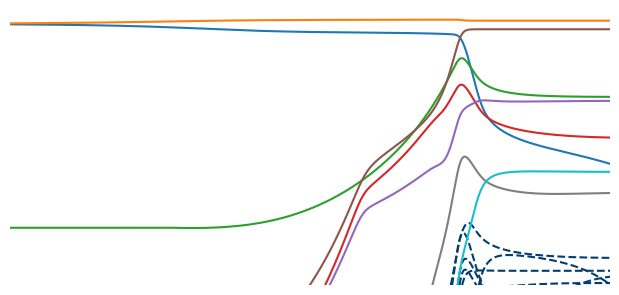

"\nfig, axes = plt.subplots(1, 1, figsize=(4, 5))\n\nfig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.135, right=0.975, bottom=0.1, top=0.93)\n\nlateline=['-.','-',':','--']\n\n#for i in range(10,fnNucs):\n#    plt.plot(soltime/timeunit, A[i]*solY[i],lateline[(Z[i]-A[i])% 4], color=colors[A[i]-8], label=Y_labels[i])\n\nfor i in range(10,fnNucs):\n    plt.plot(soltime/timeunit, A[i]*solY[i],'-' if i==11 else lateline[A[i]% 4], color=colors[(i-11)//4], label=Y_labels[i])\n\n\n\n#plt.plot(soltime/timeunit, A[10]*solY[10],'k:', label='Be9')\n#for i in range(11,fnNucs):\n#    plt.plot(soltime/timeunit, A[i]*solY[i],lateline[i], color=colors[i% 4], label=Y_labels[i])\n\n  \n#plt.axvline(soltime[1200]/timeunit)\nplt.xlabel('Time (s)')\nplt.ylabel('Mass fraction')\nplt.ylim(1e-35,1e-13)\nxlims=(10,2e4)\nplt.xlim(*xlims)\nplt.xscale('log')\nplt.yscale('log')\n\n\n\nplt.show()\n\n######\n\nplt.figure('step size')\nplt.plot(range(len(soltime)),[(soltime[i]-soltime[i-1])/timeunit for i in range

In [130]:
# Plot the results    
#soltime=midsoltimes[50]
#solY=midsolYs[50]


#plt.figure('abundance',figsize=(6.4, 8))
fig, axes = plt.subplots(1, 1, figsize=(6, 2.75))

fig.subplots_adjust(wspace=0.5, hspace=0., left=0, right=1, bottom=0, top=1)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors*=8
line=['-']*10+['--']*10+[':']*10+['-.']*10+['-']*10+['--']*10+[':']*10+['-.']*10

AUblue=np.array([0, 61, 115])/255
for i in range(10,fnNucs):
    plt.plot(soltime/timeunit, A[i]*solY[i],'--',color=AUblue)
for i in [6,8]:
    plt.plot(soltime/timeunit, A[i]*solY[i],'--',color=AUblue)
for i in [0,1,2,3,4,5,7,9]:
    plt.plot(soltime/timeunit, A[i]*solY[i],line[i], color=colors[i], label=Y_labels[i])
plt.plot(soltime/timeunit, A[19]*solY[19],'k--', label='Other')

#plt.axvline(soltime[1150]/timeunit)
#plt.xlabel('Time (s)')
#plt.ylabel('Mass fraction')
xlims=(t_ini/timeunit,7.5e3)
plt.ylim(1e-15,3)
#xlims=(0.001,0.1)
#plt.ylim(1e-1,3)
plt.xlim(*xlims)
plt.xscale('log')
plt.yscale('log')
plt.axis('off')
#plt.legend()
fig.savefig('TeX/cover/abundancelong.pdf')
plt.show()

####
'''
fig, axes = plt.subplots(1, 1, figsize=(4, 5))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.135, right=0.975, bottom=0.1, top=0.93)

lateline=['-.','-',':','--']

#for i in range(10,fnNucs):
#    plt.plot(soltime/timeunit, A[i]*solY[i],lateline[(Z[i]-A[i])% 4], color=colors[A[i]-8], label=Y_labels[i])

for i in range(10,fnNucs):
    plt.plot(soltime/timeunit, A[i]*solY[i],'-' if i==11 else lateline[A[i]% 4], color=colors[(i-11)//4], label=Y_labels[i])



#plt.plot(soltime/timeunit, A[10]*solY[10],'k:', label='Be9')
#for i in range(11,fnNucs):
#    plt.plot(soltime/timeunit, A[i]*solY[i],lateline[i], color=colors[i% 4], label=Y_labels[i])

  
#plt.axvline(soltime[1200]/timeunit)
plt.xlabel('Time (s)')
plt.ylabel('Mass fraction')
plt.ylim(1e-35,1e-13)
xlims=(10,2e4)
plt.xlim(*xlims)
plt.xscale('log')
plt.yscale('log')



plt.show()

######

plt.figure('step size')
plt.plot(range(len(soltime)),[(soltime[i]-soltime[i-1])/timeunit for i in range(len(soltime))] )

plt.yscale('log')
plt.xlabel('step')
plt.ylabel('stepsize in seconds')
plt.show()

plt.figure('abundance',figsize=(6.4, 8))

for i in range(fnNucs):
      plt.plot(range(len(soltime)), A[i]*solY[i],line[i], color=colors[i], label=Y_labels[i])

plt.xlabel('step')
plt.ylabel('Mass fraction')
plt.ylim(1e-80,1)
#plt.xlim(0,20)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='right')
plt.show()
'''